# Aprendizaje Supervisado

En la industria del trading algorítmico, las etiquetas para predicción no están del todo claras en un comienzo. Además, el hecho de estar trabajando con series de tiempo complica el trabajo. Vamos a dejar un poco de lado este hecho y vamos a ver si podemos generar características útiles con los datos.

Comencemos como en todos los prácticos: descargando los datos con los cuales vamos a trabajar.

In [1]:
from pandas_datareader import data

tickers = ['MELI']

# Definimos el rango de fechas deseado
start_date = '2020-01-01'
end_date = '2020-12-31'

# Obtenemos un DataFrame
df = data.DataReader(
    tickers, 
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
).droplevel("Symbols", axis=1)

df.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,610.190002,610.190002,615.840027,576.940002,576.940002,589200
2020-01-03,607.799988,607.799988,609.840027,600.059998,602.619995,320900
2020-01-06,606.549988,606.549988,613.789978,601.000000,601.039978,209700
2020-01-07,625.000000,625.000000,627.969971,604.739990,606.640015,480900
2020-01-08,633.440002,633.440002,637.820007,624.549988,625.000000,334600


### Hagamos Análisis Técnico!

El *análisis técnico* es el arte (algunas personas le dicen ciencia) de predecir los movimientos futuros de los activos financieros en base a su comportamiento en el pasado. Como con la predicción del clima, puede no ser preciso, pero quizás pueda dar algunas ideas de cómo se pueden mover ciertos activos y nos permita tomar decisiones de inversión a partir de esto.

Vamos a tener ciertas suposiciones claves para hacer con respecto a esto:
- **Alta liquidez**: Se asume que las acciones con las que se trabaja tienen un alto volumen de negociación. Si una acción se negocia mucho, es mucho más difícil manipular su precio, por lo que seguiría un curso "de manual", si es que se encuentra ese manual...
- **No hay cambios artificiales de precios**: Las acciones pagan dividendos (como el cupón de un bono) o, en algunos casos, pueden ser divididas (mediante una acción que se denomina "split"). Estas acciones pueden cambiar de manera artificial el precio de una acción. Para poder tener esto en cuenta, es necesario tener el precio de una acción "ajustado" por sus movimientos artificiales. Por suerte, nuestra fuente de datos ya soluciona esto.
- **No hay "cisnes negros"**: El análisis técnico no puede tener en cuenta noticias externas que puedan afectar al desempeño de una acción de manera sorpresiva, como por ejemplo la muerte de su CEO o un ataque terrorista en el que se viera afectada (o tal vez una pandemia).

En resumen, el análisis técnico utiliza la información capturada en el precio de un activo para interpretar qué es lo que el mercado dice, para formar una visión del futuro.

Claramente, esto puede sonar a chamuyo, pero puede ser algo de qué agarrarse cuando no se tiene mucha más información con la cual trabajar, ya que ha mostrado ser de utilidad en mercados muy grandes, como en EE.UU.

Otra cosa a tener en cuenta: Los datos históricos de mercado generan **series de tiempo**, que son un fenómeno un poco lejano a los datos estáticos. En este práctico vamos a probar las herramientas aprendidas en la teoría y ver si pueden tener incidencia a la hora de trabajar con estas series de tiempo.

Vamos a hacer todo esto primero con las acciones de Mercado Libre, para tener una idea de cómo se ve, aplicando la librería de pandas `ta` (https://github.com/bukosabino/ta).

In [2]:
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=de870f78f9bedbdd3787f5ace70ca6c20c8382f4cbf273d986d0a7eecc748751
  Stored in directory: c:\users\exequ\appdata\local\pip\cache\wheels\bb\7c\a0\9c72e50ddef1f7c3d9003bf4ccc5d5c8deb24828d4eb156fc8
Successfully built ta


# Indicadores Técnicos #

La librería tiene varios de los más usados, veamos:

- Medias Móviles: Se hace un promedio de los precios anteriores al día que se está tomando. Existen dos de las medias más comunes. La media *simple* (SMA) hace un promedio simple de los precios pasados, mientras que la media *exponencial* (EMA) multiplica cada elemento por un peso que va creciendo de manera exponencial hasta el presente. Aquí el hiperparámetro importante es la cantidad de períodos hacia atrás que se usan en el cálculo. Las medias móviles son indicadores de *tendencia* del precio de un activo (https://www.investopedia.com/terms/m/movingaverage.asp).
- Bandas de Bollinger (BB): Indicador de volatilidad, Una vez se tiene la media móvil, se dibuja además un valor de dos desviaciones estándar hacia arriba y hacia abajo del precio del activo (https://en.wikipedia.org/wiki/Bollinger_Bands).
- Línea de Acumulación/Distribución (ADL/I): Indicador que utiliza el volumen de venta, junto con los precios del activo. Su fórmula de cálculo se encuentra en https://www.investopedia.com/terms/a/accumulationdistribution.asp. Ayuda a ver cuán fuerte es una tendencia, ya que si un precio sube y este indicador no lo hace, quiere decir que no hay suficiente ímpetu como para mantener la suba y puede volver a bajar.

Existen mucho más ejemplos, los cuales están en la documentación y la librería, probemos uno.

<AxesSubplot:xlabel='Date'>

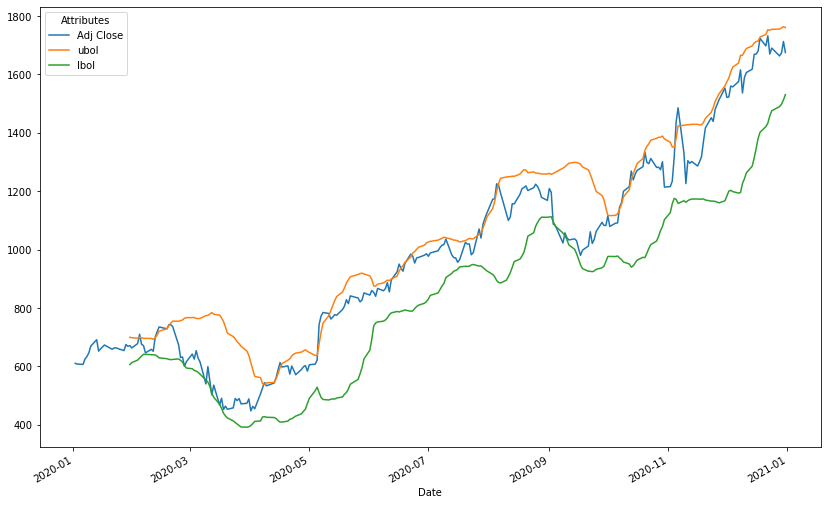

In [3]:
import ta
df["ubol"] = ta.volatility.bollinger_hband(df["Adj Close"])
df["lbol"] = ta.volatility.bollinger_lband(df["Adj Close"])
df[["Adj Close", "ubol", "lbol"]].plot(figsize=(14,9))

# Backtesting de Estrategias

Lo importante aquí es aprender cómo actuar a partir de cada señal que se recibe. Para eso comenzaremos a hacer *backtesting*, es decir, vamos a implementar una estrategia de inversión y la vamos a testear en el pasado, para ver si tiene sentido aplicarla.

Por ejemplo, la "teoría" de las bandas de Bollinger dice que las señales de compra se emiten cuando el precio está por debajo de la banda inferior y habría que vender el activo cuando el precio se va por encima de la banda superior. Es posible hacer de forma automática la señal de las bandas con la librería `ta`, el ejemplo está en su github. Para juntar información de más de una media móvil se puede usar el indicador MACD.

Tenemos que etiquetar nuestros datos si queremos aplicar un poco de aprendizaje supervisado! Para eso, vamos a crear etiquetas simples, para saber si al comprar la acción se ganó dinero. Vamos a tomar el precio de la acción en una fecha y compararlo con el precio en una fecha hacia adelante. Podemos usar una semana, o un mes, o quizás hasta un año. Por ahora, hagamos estrategias diarias y etiquetemos con 1 si, al día siguiente, el precio subió o -1 si el precio bajó.

In [4]:
# Retornos unitarios en 'Adj Close'
df['Retornos'] = df['Adj Close'].pct_change()

# Agrego Retorno shifteado para evaluar subida o bajada en precio, etiquetando con 1 o -1
df['Retornos_shift'] = df['Retornos'].shift(-1)

# Etiquetado
df['Etiqueta'] = df['Retornos_shift'].apply(lambda x: -1 if x <= 0 else 1)

df.head(3)

Attributes,Adj Close,Close,High,Low,Open,Volume,ubol,lbol,Retornos,Retornos_shift,Etiqueta
Date,,,,,,,,,,,
2020-01-02,610.190002,610.190002,615.840027,576.940002,576.940002,589200,NaN,NaN,NaN,-0.003917,-1
2020-01-03,607.799988,607.799988,609.840027,600.059998,602.619995,320900,NaN,NaN,-0.003917,-0.002057,-1
2020-01-06,606.549988,606.549988,613.789978,601.000000,601.039978,209700,NaN,NaN,-0.002057,0.030418,1


Una vez las etiquetas estén listas, comencemos a juntar señales, que van a ser nuestros features! Utilizar algunas de la lista que figura en el Github de `ta`, son muchas, así que tomar algunas que parezcan interesantes o que pueden agregar variabilidad a los resultados (cómo podríamos ver eso?):

#### Volume

* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)

#### Volatility

* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)

#### Trend

* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)

#### Momentum

* Money Flow Index (MFI)
* Relative Strength Index (RSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO)

#### Others

* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)

Vamos a dejarlas en el mismo DataFrame, como hicimos con las bandas de Bollinger. 

In [10]:
# Se toma como criterio inicial, elegir dos subindicadores de la lista anterior

# Volume
from ta.volume import AccDistIndexIndicator
from ta.volume import VolumePriceTrendIndicator

ADI = AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], fillna=True)
VPT = VolumePriceTrendIndicator(close=df['Close'], volume=df['Volume'], fillna=True)

df['ADI'] = ADI.acc_dist_index()
df['VPT'] = VPT.volume_price_trend()

# df.head()

In [28]:
# Volatility

#(Ya están agregados dos indicadores con BollingerBands)
from ta.volatility import AverageTrueRange

ATR = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], fillna=True) # Hay un parámwtro windows que no puedo ingresar VER ERROR

df['ATR'] = ATR.average_true_range()
# df.tail()

In [27]:
# Trend

from ta.trend import WMAIndicator
from ta.trend import kst

WMA = WMAIndicator(close=df['Close'], fillna=True)
KST = kst(close=df['Close'], fillna=True)

df['WMA'] = WMA.wma()
df['KST'] = KST
# df.tail()

In [29]:
# Momentum

from ta.momentum import RSIIndicator
from ta.momentum import AwesomeOscillatorIndicator

RSI = RSIIndicator(close=df['Close'], fillna=True)
AOI = AwesomeOscillatorIndicator(high=df['High'], low=df['Low'], fillna=True)

df['RSI'] = RSI.rsi()
df['AOI'] = AOI.awesome_oscillator()

df.tail()

Attributes,Adj Close,Close,High,Low,Open,Volume,ubol,lbol,Retornos,Retornos_shift,Etiqueta,ADI,VPT,ATR,KST,WMA,AOI,RSI
Date,,,,,,,,,,,,,,,,,,
2020-12-24,1690.479980,1690.479980,1694.479980,1665.900024,1672.000000,132800,1754.756073,1475.663946,0.012257,-0.015830,-1,1.033272e+07,-13463.196333,53.143708,208.893716,1693.144233,194.427296,64.079939
2020-12-28,1663.719971,1663.719971,1703.319946,1625.699951,1700.000000,285900,1755.562921,1489.886090,-0.015830,0.005872,1,1.032690e+07,-2897.966312,54.892014,204.484632,1689.198668,180.384438,60.315991
2020-12-29,1673.489990,1673.489990,1689.410034,1640.030029,1680.000000,278300,1759.323344,1498.141671,0.005872,0.023573,1,1.042575e+07,-2891.460927,54.498300,200.107272,1686.192442,166.053767,61.211799
2020-12-30,1712.939941,1712.939941,1723.959961,1659.599976,1690.000000,304300,1764.047693,1512.545312,0.023573,-0.022021,-1,1.062585e+07,8807.691520,55.202706,194.342157,1690.976207,148.336022,64.678922
2020-12-31,1675.219971,1675.219971,1718.589966,1660.900024,1718.589966,254200,1760.756902,1531.072102,-0.022021,NaN,1,1.049784e+07,1575.766884,55.380365,188.908520,1687.251535,134.679283,59.227583


## ¿Cuáles parecen ser las mejores señales para inferir 'algo'?

Es probable que las mismas cambien a medida que pase el tiempo. Algo *muy importante* al trabajar con datos financieros es separar de forma correcta los datos de training y test, ya que siempre queremos hacer inferencias del futuro en base a datos del pasado (https://www.datapred.com/blog/the-basics-of-backtesting).

Vamos a dividir nuestros datos de forma que podamos entrenar una predicción cada trimestre del año 2020. Para eso vamos a poder usar los datos desde comienzo del 2020.

Hagamos clasificación binaria, ya que tenemos nuestras etiquetas +1 y -1. K Nearest Neighbors parece interesante para hacer esto, pero también se puede probar algún otro clasificador.

Reportar para cada trimestre:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

## Finalmente, probar la estrategia

Si tomamos la decisión de comprar la acción cuando la etiqueta es +1 y vender (quedarnos con el dinero) cuando la etiqueta es -1 al comienzo de cada día desde el 01/04/2020, cómo nos habrá ido? Supongamos que comenzamos con \$10.000 y tomemos la diferencia porcentual entre el precio de Cierre del primer día de cada mes para ver si ganamos dinero. Con esto completaríamos un flow de backtesting y vamos a poder evaluar si esta estrategia funciona con la acción MELI.

Si hay tiempo, se puede usar esto para otras acciones.